# Analysis of Eviction in US Counties & ML Model to Predict Eviction.

Importing Libraries
----

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import svm
from sklearn import linear_model


from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import make_scorer, r2_score, explained_variance_score, mean_absolute_error, mean_squared_error 

#setting max number of columns to display == 25 in pandas options.
pd.options.display.max_columns = 30

Data Collection
--------------------------------

Data Source :
>In April 2018, the first-ever data set about evictions across 48 states and the District of Columbia was released by Eviction Lab—Desmond’s research group at Princeton University. To date, the Lab had collected 83 million records and it shows that in 2016.

What is our data?

>This research uses data from The Eviction Lab at Princeton University, a project directed by Matthew Desmond and designed by Ashley Gromis, Lavar Edmonds, James Hendrickson, Katie Krywokulski, Lillian Leung, and Adam Porton. The Eviction Lab is funded by the JPB, Gates, and Ford Foundations as well as the Chan Zuckerberg Initiative.

Where are we getting the data?

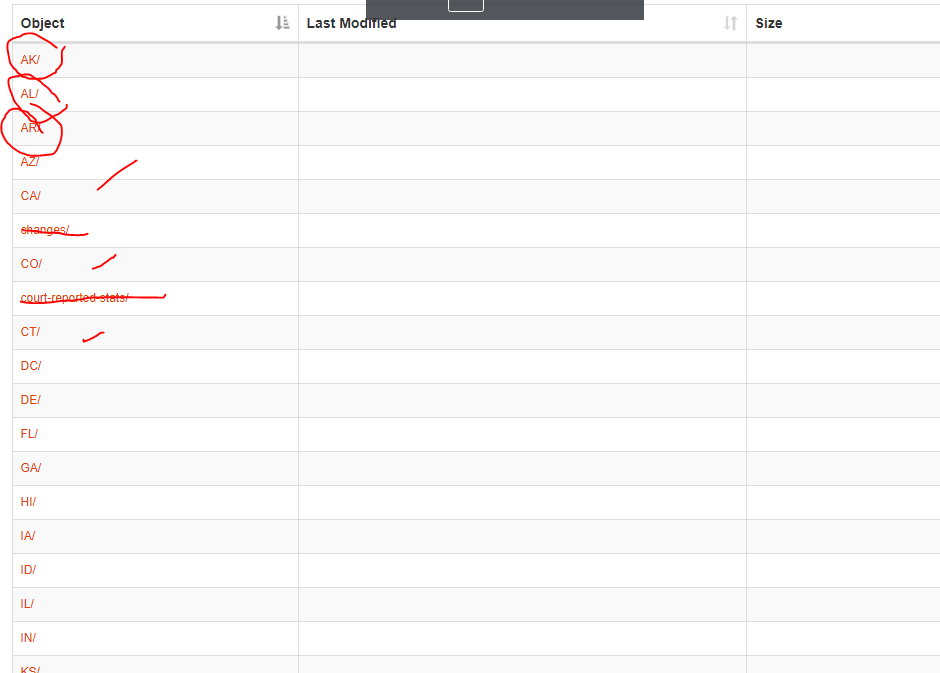

In [2]:
from IPython.display import Image

Image(filename='dataCollection/DataSourcePage.PNG') 

As you can see,there is table with state-wise folder links, and when you click on it you will see the below screen.

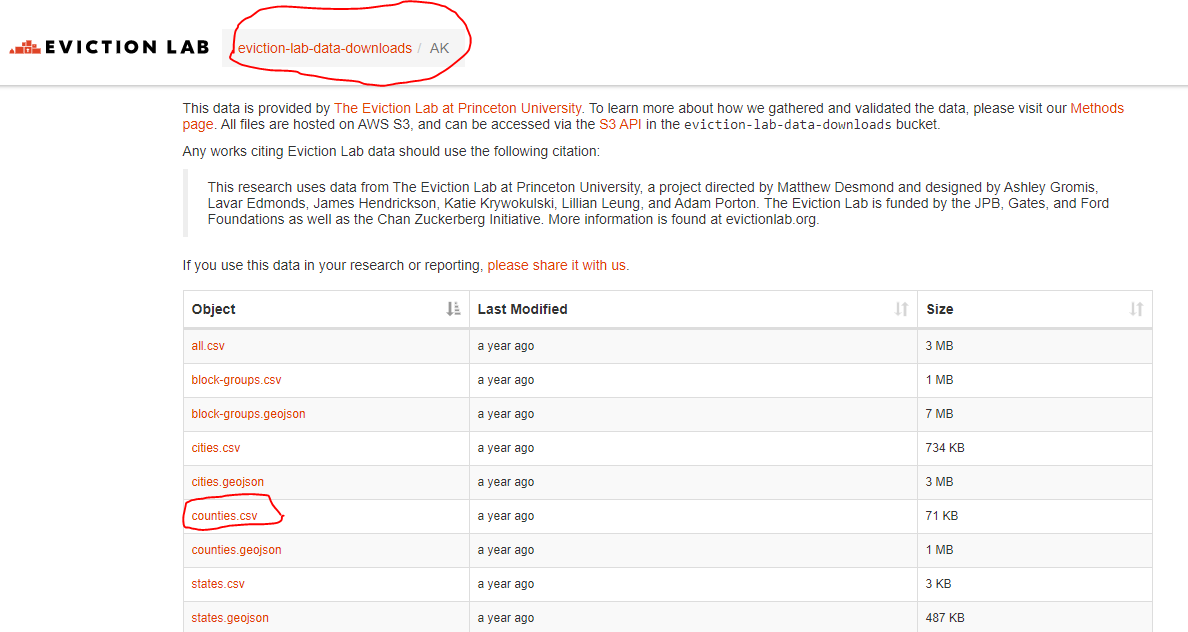

In [3]:
Image(filename='dataCollection/CountiesDatainState.PNG')

And we are interested in "counties.csv" file from every state folder. So, we will get the url of these files, and using list comprehension we will build a list of DataFrames and once we have all those, we can merge them. 

In [4]:
#firstly making a list of states

states = ["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "IA", 
     "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO", "MS",
     "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK", "OR", "PA",
     "RI", "SC", "SD", "TN", "TX", "US", "UT", "VA", "VT", "WA", "WI", "WV", "WY"]

len(states)

52

In [5]:
#manipulating link with the state index in it

for i in range(3):
    
    url = "https://eviction-lab-data-downloads.s3.amazonaws.com/{state}/counties.csv"\
    .format(state = states[i])
    
    print(url, '\n click the above for {state} states counties csv file.'.format(state = states[i]))

https://eviction-lab-data-downloads.s3.amazonaws.com/AK/counties.csv 
 click the above for AK states counties csv file.
https://eviction-lab-data-downloads.s3.amazonaws.com/AL/counties.csv 
 click the above for AL states counties csv file.
https://eviction-lab-data-downloads.s3.amazonaws.com/AR/counties.csv 
 click the above for AR states counties csv file.


In [6]:
#df for Alaska state counties data

#and getting the column_names from that

counties_AK = pd.read_csv("https://eviction-lab-data-downloads.s3.amazonaws.com/AK/counties.csv")

column_names = counties_AK.columns

In [7]:
counties_AK.shape #27 columns, 493 rows

(493, 27)

In [8]:
#building a list of data frames, 

url = "https://eviction-lab-data-downloads.s3.amazonaws.com/{state}/counties.csv"

counties_df_list = [(pd.read_csv(url.format(state = states[i]), skiprows=1)\
                     .set_axis(column_names, axis='columns', inplace=False)) for i in range(len(states))]
    
len(counties_df_list)   

52

In [38]:
#then concatenating dfs outside loop all together as 

#counties_us

counties_us = pd.concat(counties_df_list, ignore_index=True)

counties_us.shape

(106820, 27)

In [39]:
counties_us.tail()

,GEOID,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
106815,56045,2012,Weston County,Wyoming,7152.0,10.82,704.0,21.97,740.0,57738.0,178200.0,19.6,92.2,0.21,3.27,0.66,0.53,0.0,3.13,0.0,0.0,0.0,0.0,0.0,0,0,0
106816,56045,2013,Weston County,Wyoming,7152.0,10.82,720.0,21.97,740.0,57738.0,178200.0,19.6,92.2,0.21,3.27,0.66,0.53,0.0,3.13,0.0,0.0,0.0,0.0,0.0,0,0,0
106817,56045,2014,Weston County,Wyoming,7152.0,10.82,736.0,21.97,740.0,57738.0,178200.0,19.6,92.2,0.21,3.27,0.66,0.53,0.0,3.13,0.0,0.0,0.0,0.0,0.0,0,0,0
106818,56045,2015,Weston County,Wyoming,7152.0,10.82,752.0,21.97,740.0,57738.0,178200.0,19.6,92.2,0.21,3.27,0.66,0.53,0.0,3.13,0.0,0.0,0.0,0.0,0.0,0,0,0
106819,56045,2016,Weston County,Wyoming,7152.0,10.82,768.0,21.97,740.0,57738.0,178200.0,19.6,92.2,0.21,3.27,0.66,0.53,0.0,3.13,0.0,0.0,0.0,0.0,0.0,0,0,0


Here we go, we have big data set of 1,06,820 rows and the same 27 columns.

In [40]:
#dropping the columns not needed for our study.

#low-flag, GEOID, 
#imputed, 
#subbed, 

counties_us = counties_us.drop(["GEOID", "low-flag", "imputed", "subbed"], axis = 1)
 
counties_us.columns

Index(['year', 'name', 'parent-location', 'population', 'poverty-rate',
       'renter-occupied-households', 'pct-renter-occupied',
       'median-gross-rent', 'median-household-income', 'median-property-value',
       'rent-burden', 'pct-white', 'pct-af-am', 'pct-hispanic', 'pct-am-ind',
       'pct-asian', 'pct-nh-pi', 'pct-multiple', 'pct-other',
       'eviction-filings', 'evictions', 'eviction-rate',
       'eviction-filing-rate'],
      dtype='object')

Understanding the dimensions and details of the dataset
---------

In [42]:
#top 5 records of the data

counties_us.head()

,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate
0,2001,Aleutians East Borough,Alaska,2697.0,21.83,225.0,41.83,710.0,47875.0,99500.0,18.6,19.32,1.56,12.57,37.04,26.40,0.30,2.71,0.11,NaN,NaN,NaN,NaN
1,2002,Aleutians East Borough,Alaska,2697.0,21.83,230.0,41.83,710.0,47875.0,99500.0,18.6,19.32,1.56,12.57,37.04,26.40,0.30,2.71,0.11,NaN,NaN,NaN,NaN
2,2003,Aleutians East Borough,Alaska,2697.0,21.83,234.0,41.83,710.0,47875.0,99500.0,18.6,19.32,1.56,12.57,37.04,26.40,0.30,2.71,0.11,NaN,NaN,NaN,NaN
3,2004,Aleutians East Borough,Alaska,2697.0,21.83,239.0,41.83,710.0,47875.0,99500.0,18.6,19.32,1.56,12.57,37.04,26.40,0.30,2.71,0.11,NaN,NaN,NaN,NaN
4,2005,Aleutians East Borough,Alaska,2959.0,8.37,244.0,58.59,654.0,56250.0,122100.0,18.0,9.97,9.83,9.50,17.17,47.48,0.34,5.58,0.14,NaN,NaN,NaN,NaN


In [43]:
#counties_us.shape

print('Total no. of. records/observations:', counties_us.shape[0])

print('Total no. of. attributes/variables:', counties_us.shape[1])

Total no. of. records/observations: 106820
Total no. of. attributes/variables: 23


>>Renaming the columns
>>-------------------
>>>Replacing '-' with '_'
>>> & name, parent-location

In [44]:
columns = counties_us.columns

renames = {}

for col in columns:
    renames[col] = col.replace('-', '_')

counties_us = counties_us.rename(columns=renames)

counties_us.columns

Index(['year', 'name', 'parent_location', 'population', 'poverty_rate',
       'renter_occupied_households', 'pct_renter_occupied',
       'median_gross_rent', 'median_household_income', 'median_property_value',
       'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind',
       'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'eviction_filings', 'evictions', 'eviction_rate',
       'eviction_filing_rate'],
      dtype='object')

In [45]:
#rename name to county and parent-location to state

counties_us = counties_us.rename(columns = {'name':'county','parent_location':'state'}, inplace = False) 

counties_us.columns

Index(['year', 'county', 'state', 'population', 'poverty_rate',
       'renter_occupied_households', 'pct_renter_occupied',
       'median_gross_rent', 'median_household_income', 'median_property_value',
       'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind',
       'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'eviction_filings', 'evictions', 'eviction_rate',
       'eviction_filing_rate'],
      dtype='object')

In [46]:
#column names of data

Col_list = counties_us.columns.tolist()

Col_list

['year',
 'county',
 'state',
 'population',
 'poverty_rate',
 'renter_occupied_households',
 'pct_renter_occupied',
 'median_gross_rent',
 'median_household_income',
 'median_property_value',
 'rent_burden',
 'pct_white',
 'pct_af_am',
 'pct_hispanic',
 'pct_am_ind',
 'pct_asian',
 'pct_nh_pi',
 'pct_multiple',
 'pct_other',
 'eviction_filings',
 'evictions',
 'eviction_rate',
 'eviction_filing_rate']

In [48]:
#col data types
#sorting by type for simple vision and understanding

counties_us.dtypes.sort_values()

year                            int64
evictions                     float64
eviction_filings              float64
pct_other                     float64
pct_multiple                  float64
pct_nh_pi                     float64
pct_asian                     float64
pct_am_ind                    float64
pct_hispanic                  float64
pct_af_am                     float64
eviction_rate                 float64
pct_white                     float64
median_property_value         float64
median_household_income       float64
median_gross_rent             float64
pct_renter_occupied           float64
renter_occupied_households    float64
poverty_rate                  float64
population                    float64
rent_burden                   float64
eviction_filing_rate          float64
state                          object
county                         object
dtype: object

>We have 1 int type, 20 float type and 2 object type variables.

Data Dictionary:
----

In [49]:
col_meaning_list = [ "The year of which the recorded information belongs to.",
"Census location name (modified for display on map)", 
"Parent location of given geography.- USA for states, state for counties and cities, counties for tracts and block groups", 
"Total population of the county for the corresponding year.", 
"% of the population with income in the past 12 months below the poverty level", 
"Interpolated count of renter-occupied households - Based on Census and ESRI Business Analyst demographic estimates", 
"% of occupied housing units that are renter-occupied. - NOTE: This is not based off of the interpolated renter-occupied-households variable", 
"Median gross rent", 
"Median household income",
"Median property value",
"Median gross rent as a percentage of household income, max is 50% representing >= 50%", 
"% population that is White alone and not Hispanic or Latino", 
"% population that is Black or African American alone and not Hispanic or Latino",
"% population that is of Hispanic or Latino origin",
"% population that is American Indian and Alaska Native alone and not Hispanic or Latino",
"% population that is Asian alone and not Hispanic or Latino",
"% population that is Native Hawaiian and Other Pacific Islander alone and not Hispanic or Latino",  
"% population that is two or more races and not Hispanic or Latino",
"% population that is other race alone and not Hispanic or Latino",
"All eviction cases filed in an area, including multiple cases filed against the same address in the same year",                    
"Number of eviction judgments in which renters were ordered to leave in a given area and year  - Only counts a single address which received an eviction judgment per year",
"Ratio of the number of renter-occupied households in an area that received an eviction judgement in which renters were ordered to leave - Only counts a single address per year which received an eviction judgment",
"Ratio of the number of evictions filed in an area over the number of renter-occupied homes in that area - Counts all eviction cases filed in an area, including multiple cases filed against the same address in the same year"]

In [50]:
data_dict = {}

for i in range(len(Col_list)):
    data_dict[Col_list[i]] = col_meaning_list[i]
    
data_dict   

{'year': 'The year of which the recorded information belongs to.',
 'county': 'Census location name (modified for display on map)',
 'state': 'Parent location of given geography.- USA for states, state for counties and cities, counties for tracts and block groups',
 'population': 'Total population of the county for the corresponding year.',
 'poverty_rate': '% of the population with income in the past 12 months below the poverty level',
 'renter_occupied_households': 'Interpolated count of renter-occupied households - Based on Census and ESRI Business Analyst demographic estimates',
 'pct_renter_occupied': '% of occupied housing units that are renter-occupied. - NOTE: This is not based off of the interpolated renter-occupied-households variable',
 'median_gross_rent': 'Median gross rent',
 'median_household_income': 'Median household income',
 'median_property_value': 'Median property value',
 'rent_burden': 'Median gross rent as a percentage of household income, max is 50% representin

In [51]:
#what is 'county'?

data_dict['county']

'Census location name (modified for display on map)'

In [21]:
#what is evictions?

data_dict['evictions']

'Number of eviction judgments in which renters were ordered to leave in a given area and year  - Only counts a single address which received an eviction judgment per year'

Summary Statistics Of Data
----

In [52]:
counties_us.describe(include='all')

,year,county,state,population,poverty_rate,renter_occupied_households,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,eviction_filings,evictions,eviction_rate,eviction_filing_rate
count,106820.000000,106820,106820,1.067780e+05,106778.000000,1.068100e+05,106778.000000,106756.000000,106766.000000,1.067420e+05,106758.000000,106778.000000,106778.000000,106778.000000,106778.000000,106778.000000,106778.000000,106778.000000,106778.000000,88300.000000,82644.000000,82644.000000,88300.000000
unique,NaN,1878,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Washington County,Texas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1020,8635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2008.003333,NaN,NaN,9.587818e+04,12.524838,1.273803e+04,27.317518,596.221243,42402.470684,1.178820e+05,26.756636,79.097042,8.779727,7.631952,1.783929,1.071664,0.075242,1.471793,0.088662,835.578041,373.946203,1.676837,3.009877
std,4.897147,NaN,NaN,3.096623e+05,6.091842,5.085263e+04,8.011314,199.374388,12086.055748,7.754642e+04,4.773501,19.590762,14.400384,12.876634,7.372981,2.431708,0.750234,1.550561,0.156170,4279.548150,1542.853163,1.977085,4.917045
min,2000.000000,NaN,NaN,6.700000e+01,0.000000,5.000000e+00,7.350000,178.000000,9333.000000,0.000000e+00,8.100000,0.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,NaN,NaN,1.102700e+04,8.230000,1.049000e+03,21.990000,461.000000,34044.000000,7.420000e+04,23.500000,68.170000,0.420000,1.312500,0.150000,0.200000,0.000000,0.720000,0.000000,3.000000,3.000000,0.320000,0.350000
50%,2008.000000,NaN,NaN,2.540100e+04,11.520000,2.551500e+03,25.930000,570.000000,40677.000000,9.600000e+04,26.700000,86.540000,1.930000,2.780000,0.280000,0.440000,0.010000,1.140000,0.040000,30.000000,25.000000,1.110000,1.460000
75%,2012.000000,NaN,NaN,6.488600e+04,15.500000,7.145500e+03,31.150000,685.000000,48384.000000,1.374000e+05,29.800000,94.520000,9.980000,7.290000,0.640000,0.980000,0.040000,1.730000,0.110000,210.000000,140.000000,2.310000,3.550000


In [53]:
#summary stats for numeric variables

counties_us.describe()

,year,population,poverty_rate,renter_occupied_households,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,eviction_filings,evictions,eviction_rate,eviction_filing_rate
count,106820.000000,1.067780e+05,106778.000000,1.068100e+05,106778.000000,106756.000000,106766.000000,1.067420e+05,106758.000000,106778.000000,106778.000000,106778.000000,106778.000000,106778.000000,106778.000000,106778.000000,106778.000000,88300.000000,82644.000000,82644.000000,88300.000000
mean,2008.003333,9.587818e+04,12.524838,1.273803e+04,27.317518,596.221243,42402.470684,1.178820e+05,26.756636,79.097042,8.779727,7.631952,1.783929,1.071664,0.075242,1.471793,0.088662,835.578041,373.946203,1.676837,3.009877
std,4.897147,3.096623e+05,6.091842,5.085263e+04,8.011314,199.374388,12086.055748,7.754642e+04,4.773501,19.590762,14.400384,12.876634,7.372981,2.431708,0.750234,1.550561,0.156170,4279.548150,1542.853163,1.977085,4.917045
min,2000.000000,6.700000e+01,0.000000,5.000000e+00,7.350000,178.000000,9333.000000,0.000000e+00,8.100000,0.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,1.102700e+04,8.230000,1.049000e+03,21.990000,461.000000,34044.000000,7.420000e+04,23.500000,68.170000,0.420000,1.312500,0.150000,0.200000,0.000000,0.720000,0.000000,3.000000,3.000000,0.320000,0.350000
50%,2008.000000,2.540100e+04,11.520000,2.551500e+03,25.930000,570.000000,40677.000000,9.600000e+04,26.700000,86.540000,1.930000,2.780000,0.280000,0.440000,0.010000,1.140000,0.040000,30.000000,25.000000,1.110000,1.460000
75%,2012.000000,6.488600e+04,15.500000,7.145500e+03,31.150000,685.000000,48384.000000,1.374000e+05,29.800000,94.520000,9.980000,7.290000,0.640000,0.980000,0.040000,1.730000,0.110000,210.000000,140.000000,2.310000,3.550000
max,2016.000000,1.003839e+07,56.920000,1.792186e+06,100.000000,2001.000000,123453.000000,1.000001e+06,50.100000,100.000000,86.760000,98.710000,94.950000,47.480000,48.890000,33.330000,4.900000,143753.000000,47716.000000,24.160000,118.620000


In [54]:
#summary stats for object type data

counties_us.describe(include = 'object')

,county,state
count,106820,106820
unique,1878,51
top,Washington County,Texas
freq,1020,8635


In [55]:
counties_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106820 entries, 0 to 106819
Data columns (total 23 columns):
year                          106820 non-null int64
county                        106820 non-null object
state                         106820 non-null object
population                    106778 non-null float64
poverty_rate                  106778 non-null float64
renter_occupied_households    106810 non-null float64
pct_renter_occupied           106778 non-null float64
median_gross_rent             106756 non-null float64
median_household_income       106766 non-null float64
median_property_value         106742 non-null float64
rent_burden                   106758 non-null float64
pct_white                     106778 non-null float64
pct_af_am                     106778 non-null float64
pct_hispanic                  106778 non-null float64
pct_am_ind                    106778 non-null float64
pct_asian                     106778 non-null float64
pct_nh_pi                    

In [57]:
counties_us['state'].nunique()

51

There are 51 labels in the states attribute, it is because the data also included the 'District of Columbia' - a federal district.

Exploratory Data Analysis
--------

>Missing Value Analysis
>---------------

Looking for null values

In [58]:
counties_us.isnull().sum()

year                              0
county                            0
state                             0
population                       42
poverty_rate                     42
renter_occupied_households       10
pct_renter_occupied              42
median_gross_rent                64
median_household_income          54
median_property_value            78
rent_burden                      62
pct_white                        42
pct_af_am                        42
pct_hispanic                     42
pct_am_ind                       42
pct_asian                        42
pct_nh_pi                        42
pct_multiple                     42
pct_other                        42
eviction_filings              18520
evictions                     24176
eviction_rate                 24176
eviction_filing_rate          18520
dtype: int64

From the above, we can see that the data has 24176 null values under the attribute 'evictions', 'eviction_filings', 'eviction_rate' and 'eviction_filing_rate'. And between 40 - 80 missing values under all other attributes except year, county and state attributes.

In [59]:
(counties_us.isnull().sum()/counties_us.shape[0] *100).round(2)

year                           0.00
county                         0.00
state                          0.00
population                     0.04
poverty_rate                   0.04
renter_occupied_households     0.01
pct_renter_occupied            0.04
median_gross_rent              0.06
median_household_income        0.05
median_property_value          0.07
rent_burden                    0.06
pct_white                      0.04
pct_af_am                      0.04
pct_hispanic                   0.04
pct_am_ind                     0.04
pct_asian                      0.04
pct_nh_pi                      0.04
pct_multiple                   0.04
pct_other                      0.04
eviction_filings              17.34
evictions                     22.63
eviction_rate                 22.63
eviction_filing_rate          17.34
dtype: float64

The above gives us the understanding of the portion of missing values under each attribute in %'s.
>Only 'evictions', 'eviction_filings', 'eviction_rate' and 'eviction_filing_rate' has around 17% - 23% of missing values and the remaining have negligible missing value portion. 

Handling Missing Values:
>> 'evictions' is the target variable, so we are not going to impute the missing values in this.
>>> lets drop the rows with missing values in 'evictions'.

>> All other attribute have negligible percentage of missing values. 
>>>So we can drop them, that wont be effecting our study.

In [60]:
counties_us.shape

(106820, 23)

In [61]:
counties_us.dropna(how = 'any', inplace = True)

In [62]:
counties_us.shape

(82564, 23)

In [63]:
(counties_us.isnull().sum()/counties_us.shape[0] *100).round(2)

year                          0.0
county                        0.0
state                         0.0
population                    0.0
poverty_rate                  0.0
renter_occupied_households    0.0
pct_renter_occupied           0.0
median_gross_rent             0.0
median_household_income       0.0
median_property_value         0.0
rent_burden                   0.0
pct_white                     0.0
pct_af_am                     0.0
pct_hispanic                  0.0
pct_am_ind                    0.0
pct_asian                     0.0
pct_nh_pi                     0.0
pct_multiple                  0.0
pct_other                     0.0
eviction_filings              0.0
evictions                     0.0
eviction_rate                 0.0
eviction_filing_rate          0.0
dtype: float64

Now, we dont have missing values in our data.

>Outlier Analysis
>----

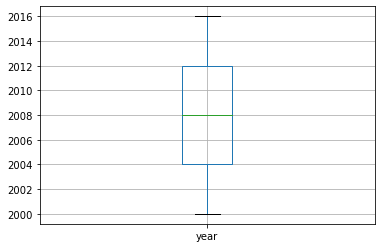

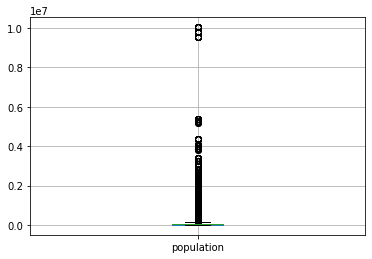

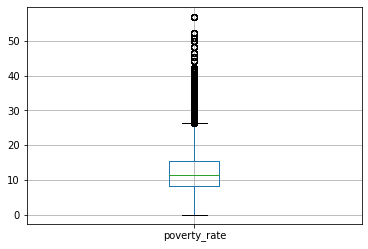

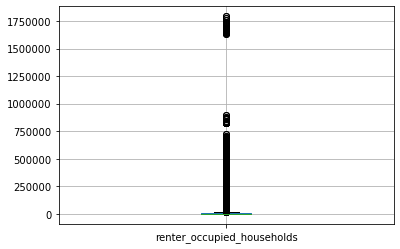

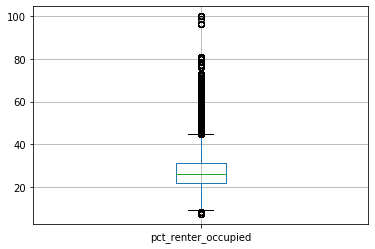

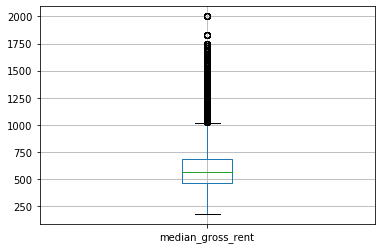

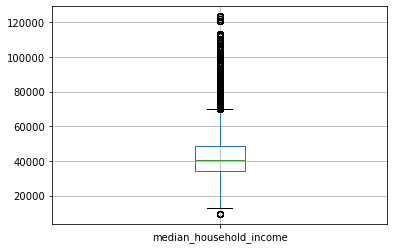

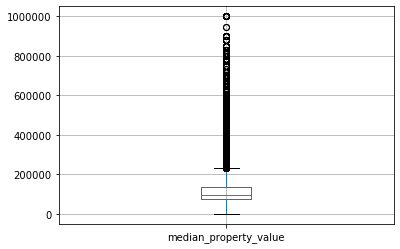

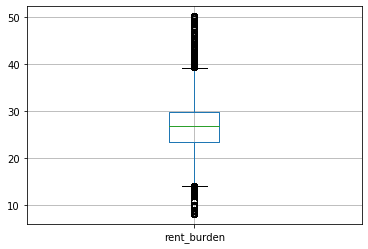

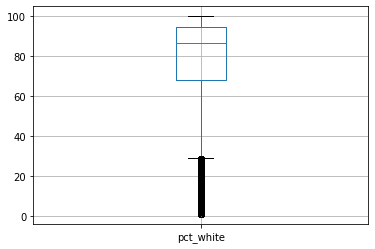

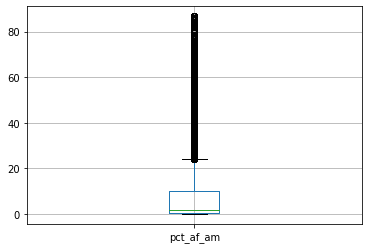

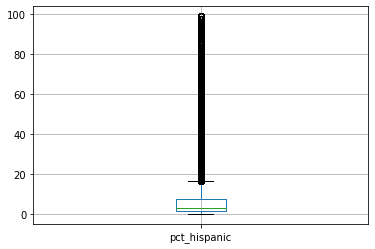

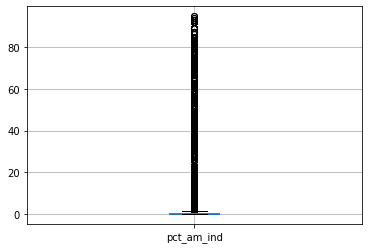

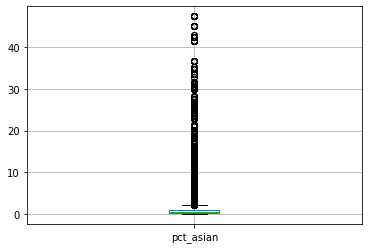

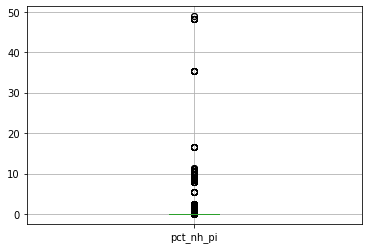

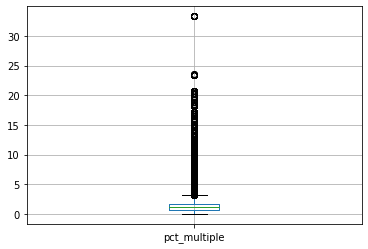

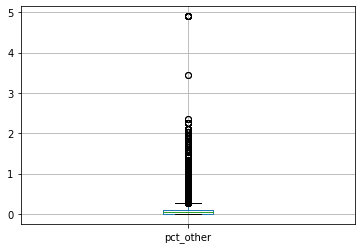

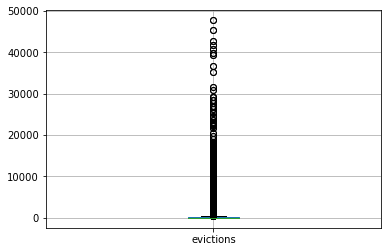

In [30]:
num_col = ['year','population','poverty_rate','renter_occupied_households','pct_renter_occupied',\
           'median_gross_rent','median_household_income','median_property_value','rent_burden',\
           'pct_white','pct_af_am','pct_hispanic','pct_am_ind','pct_asian','pct_nh_pi','pct_multiple',\
           'pct_other','evictions','eviction_filings', 'eviction_rate', 'eviction_filing_rate']
for col in num_col:
    plt.figure()
    counties_us.boxplot([col])

>Data Cleaning
>----